**Complete the details below:**

### Name: Ryno Swart


#### Student Number: 18603637

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display
from IPython.display import Image
from sklearn.metrics import confusion_matrix
from hmm_class import HMM
from gaussian import Gaussian
from utils import read_signatures, sign_norm

### A simple example

As a simple example to see what is happening, let us consider a simple example, based on the example in the code comments. Here we provide the system with 2 sequences of 1-dimensional observations for training, the first with 11 observations, and the second with 7.

By observation of the signals, it should not be hard to see that the data is roughly clustered around 3 values, namely 1.0, 0.1 and 3.5. We therefore specify 3 states.  Fitting the model yields transition probabilities between the states, as well as the parameters (means and covariances) of the Gaussian densities associated with each state.

We print the trained HMM parameters - **verify that they make sense to you.  Ensure you understand what the last row and column in the transition table are for.**

In [3]:
# Define signals
signal1 = np.array([[ 1. ,  1.1,  0.9, 1.0, 0.0,  0.2,  0.1,  0.3,  3.4,  3.6,  3.5]])
signal2 = np.array([[0.8, 1.2, 0.4, 0.2, 0.15, 2.8, 3.6]])

# Collect training data together
toy_data = np.hstack([signal1, signal2])
toy_lengths = [11, 7]

# Create and fit HMM model to data
toy_hmm = HMM()
toy_hmm.fit(toy_data,toy_lengths, 3)

toy_means = [d.get_mean() for d in toy_hmm.dists]
toy_covs = [d.get_cov() for d in toy_hmm.dists]

### Training

**Use the approach above to read in training signatures for each signatory, and train an HMM for each signatory using 5 states and diagonal covariance matrices (we will use most of these models later).**  Note that this is quite a big computation, so can take quite a while.

Marks: 0

In [4]:
sign_hmm = []
for x in np.arange(5):
    sign = read_signatures('./data/signatures/sign' + str(x+1) + '/*.txt')
    n_signs = len(sign)-12 #Only use 3 signatures
    data = sign_norm(sign[0][:2, :])
    length = [sign[0].shape[1]]
    for i in range(n_signs-1):
        signi = sign_norm(sign[i+1][:2, :])
        data = np.hstack((data,signi))
        length.append(sign[i+1].shape[1])
    #Create HMM
    sign_hmm.append(HMM(diagcov=True))
    sign_hmm[x].fit(data, length, 5)

### Sampling from an HMM

Since an HMM is a generative model, one is able to sample from the model to generate data from the distribution represented by the model.  This process interleaves sampling state transitions and observations from the corresponding state's emission density until a transition to the final non-emitting state is reached.

**Complete the implementation of the sample function in the HMM class provided in this assignment, and use it to sample two signals from the model for signatory 2.  Plot the sampled signals in separate images, colouring each point based on its associated state.  (You may simply cycle through the provided list of the 7 pre-defined colors of matplotlib below.).  (Show the transitions from one time step to the next, not just a collection of points).**

*Note that for this question, you must edit and reload the provided hmm_class.py python file.*

Marks: 2

In [ ]:
# Code added to "hmm_class.py" file where 'pass' keyword occurs:
# (This code is out of context and should not be executed)

# Sample method:
def sample(self):
    import scipy.interpolate as interpolate
    def draw_discrete_sample(discr_prob):
        if not np.sum(discr_prob) == 1:
            raise ValueError('The sum of the discrete probabilities should add to 1')
        x = np.cumsum(discr_prob)
        x = np.hstack((0.,x))
        y = np.array(range(len(x)))
        fn = interpolate.interp1d(x,y)           
        r = np.random.rand(1)
        return np.array(np.floor(fn(r)),dtype=int)[0]
    #######################################################################

    #TODO: Using the function defined above, draw samples from the HMM 
    #pass
    final_state = np.shape(self.trans)[0]-1
    state_route = np.empty((1), dtype=int)
    state_route[0] = draw_discrete_sample(self.trans[-1,:])
    while state_route[-1] != final_state:
        state_route = np.append(state_route, draw_discrete_sample(self.trans[state_route[-1],:]))
    leng = np.size(state_route)-1
    n_features = np.shape(self.data)[0]
    sample_route = np.empty((leng, n_features))
    for i in range(leng):
        sample_route[i] = self.dists[state_route[i]].sample().flatten()
    return sample_route, state_route

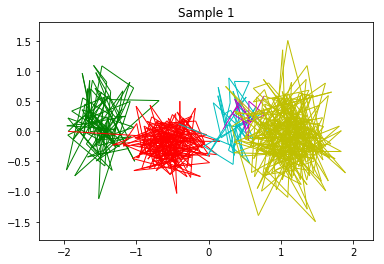

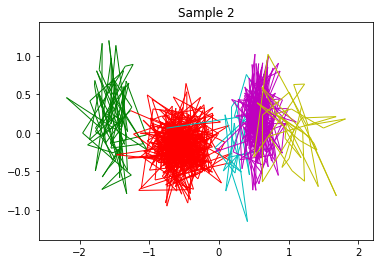

In [5]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
col_list = ['g', 'r', 'c', 'm', 'y', 'k', 'b']
cmap = ListedColormap(col_list[:5])
norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], cmap.N)
for i in range(2):
    samples, states = sign_hmm[1].sample()
    points = samples.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    #Create linecollection with coloured segements
    #This method accommodates non-sequential HMM states
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(states[1:])
    lc.set_linewidth(1)

    #Plot the figure
    plt.title('Sample ' + str(i+1))
    plt.gca().add_collection(lc)
    xmax = np.max(samples[:,0])
    xmin = np.min(samples[:,0])
    ymax = np.max(samples[:,1])
    ymin = np.min(samples[:,1])
    xrange = xmax-xmin
    yrange = ymax-ymin
    plt.ylim(ymin-0.1*yrange, ymax+0.1*yrange)
    plt.xlim(xmin-0.1*xrange, xmax+0.1*xrange)
    plt.show()

### Fitting a new signal to the model

Once one has a model (or multiple models), one may obtain a new observation.  An important question is then associating different parts of the signals with the underlying states.  This is achieved by the Viterbi algorithm.  To illustrate this, we continue with two signals for our toy example:

In [6]:
signal3 = np.array([[ 0.9515792,   0.9832767,   1.04633007,  1.01464327,  0.98207072,  1.01116689,
  0.31622856,  0.20819263,  3.57707616]])
seq3, ll3 = toy_hmm.viterbi(signal3)
#print(seq3)
#print(ll3)

signal4 = np.array([[ 1,   0.6,   0.5 , 3.57707616]]) 
seq4, ll4 = toy_hmm.viterbi(signal4)
#print(seq4)
#print(ll4)

### Visualise the different states - Viterbi on signatures

It is instructive to visualise the assignment of the observations to the different classes for signatures.

**Take 2 arbitrary training signatures from different signatories (not signatory 2 as in the example below), allocate the points to states using the Viterbi algorithm, and display the points in the signatures on separate plots, colouring each point based on its associated state. The resulting images should look like the example below (except that it used 10 hidden states):**

**Marks: 2**

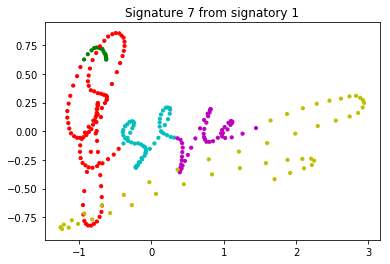

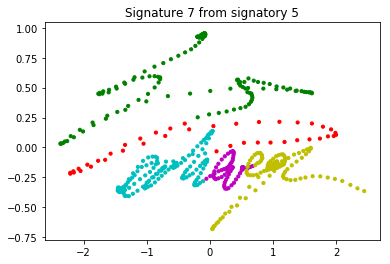

In [7]:
signa = [1, 5]
sig = 7
for i in np.arange(np.size(signa)):
    sign = read_signatures('./data/signatures/sign' + str(signa[i]) + '/*.txt')
    data = sign_norm(sign[sig][:2, :])
    s, ll = sign_hmm[signa[i]-1].viterbi(data)
    cols = np.empty(np.size(s), dtype="str")
    for x in np.arange(np.max(s)+1):
        cols[s==x] = col_list[x]
    plt.title('Signature ' + str(sig) + ' from signatory ' + str(signa[i]))
    plt.scatter(data[0,:],data[1,:], c=cols, s=10)
    plt.show()

### Calculating likelihoods

Note that the Viterbi algorithm also returns the joint log-likelihood of the observed signal and the sequence identified by the algorithm.  However, we may also be interested in this joint log-likelihood for some other sequence, or the (marginal) log-likelihood of the observation.  **Thus you must implement two functions in the HMM class which are documented in the code, namely _score and _forward.**  You can verify your score function by ensuring it returns the same log-likelihood as the viterbi function on the sequence identified by the Viterbi algorithm.  You can check your forward algorithm by explicitly scoring all the possible sequences for a short signal (such as the 4-observation toy example earlier in this notebook) and ensuring the sum of the corresponding likelihoods corresponds to the (marginal) log-likelihood returned by the forward algorithm.  *For this question, you must again edit and reload the provided hmm_class.py python file.  **Include the code cell below and its output in your submission.** *

*Note: when using the forward algorithm, you often need to add likelihoods together with vastly differing magnitudes.  This can lead to inaccuracy, overflow, underflow, and general numerical computation nastiness.  To avoid much of this unpleasantness, you will likely want to make use of numpy's logaddexp function.*

Marks: 2 for score, 2 for forward.

In [ ]:
# Code added to "hmm_class.py" file where 'pass' keyword occurs:
# (This code is out of context and should not be executed)

# Forward method:
def _forward(signal, trans, dists):
    n_states = trans.shape[0] - 1
    n_obs = signal.shape[1]
    lltable = np.zeros((n_states+1, n_obs+1))

    lltable[-1, -1] = 0
    for state in range(n_states):
        lltable[state, -1] = float("-inf")

    for time in range(n_obs):
        lltable[n_states, time] = float("-inf")
        for state in range(n_states):
            probs = np.log(trans[:, state])+lltable[:, time-1]
            ll = probs[0]
            for p in probs[1:]:
                ll = np.logaddexp(ll, p)
            lltable[state, time] = ll
            lltable[state, time] += dists[state].logf(signal[:,time].flatten())
    for state in range(n_states+1):
        probs = np.log(trans[:, state])+lltable[:, n_obs-1]
        ll = probs[0]
        for p in probs[1:]:
            ll = np.logaddexp(ll, p)
        lltable[state, n_obs] = ll

    return lltable[n_states, n_obs]

In [ ]:
# Code added to "hmm_class.py" file where 'pass' keyword occurs:
# (This code is out of context and should not be executed)

# Score method:
def _score(signal, seq, trans, dists):
    ll = dists[seq[0]].logf(signal[:,0].flatten())
    for i in np.arange(1, np.size(seq)):
        ll += np.log(trans[seq[i-1],seq[i]])
        ll += dists[seq[i]].logf(signal[:,i].flatten())
    ll += np.log(trans[seq[-1],-1])
    return ll[0,0]

In [8]:
print(toy_hmm.score(signal3, [0, 0, 0, 0, 0, 1, 1, 1, 2]))
print(toy_hmm.score(signal4, [0,1,1,2]))
print(toy_hmm.forward(signal3))
print(toy_hmm.forward(signal4))

-17.275994398
-7.96885938689
2.23882615241
-6.85288483687


# Signature classification

We now turn to classifying signatures known to come from a specific group of individuals, or signature classification.  Note that signature verification is a broader problem, where one must detect whether a signature belongs to a specific individuals - this poses complications we do not discuss further here.

For this section, we use the HMM models built earlier for our signatories, and use them to classify the 5 test signatures of each individual.  **Assuming each signatory is equally likely a priori, classify each signature using these models, and provide a confusion matrix and the test accuracy of the classifier**.

In theory, the likelihood of a signature is calculated with the forward algorithm, but it is also common to use the likelihood of the most likely sequence extracted from the Viterbi algorithm.  For this task, use the latter approach by default.

Marks: 2

In [9]:
def plot_confusion_matrix(cm, title='Confusion matrix', target_names = np.array(['1', '2', '3', '4', '5']), cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[12  0  0  0  0]
 [ 0 12  0  0  0]
 [ 0  0 12  0  0]
 [ 0  0  1 11  0]
 [ 0  0  0  0 12]]


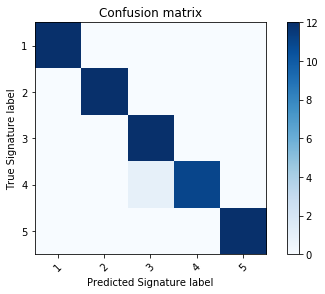

In [10]:
true_labels = np.empty(5*12)
predicted_labels = np.empty(5*12)
for x in np.arange(5):
    sign = read_signatures('./data/signatures/sign' + str(x+1) + '/*.txt')
    for i in np.arange(12):
        signi = sign_norm(sign[i+3][:2, :])
        lls = np.empty(5)
        for h in range(np.size(sign_hmm)):
            seq, ll = sign_hmm[h].viterbi(signi)
            lls[h] = ll
        true_labels[i+12*x] = x
        predicted_labels[i+12*x] = np.argmax(lls)

conf = confusion_matrix(true_labels, predicted_labels)
print(conf)
plot_confusion_matrix(conf)
plt.ylabel('True Signature label')
plt.xlabel('Predicted Signature label')
plt.show()

# Plagiarism declaration

** Add the plagiarism declaration from the University's Plagiarism Policy in this cell.**

### Plagiarism Declaration

- I have read and understand the Stellenbosch University Policy on Plagiarism and the definitions of
plagiarism and self-plagiarism contained in the Policy [Plagiarism: The use of the ideas or material
of others without acknowledgement, or the re-use of one’s own previously evaluated or published
material without acknowledgement or indication thereof (self-plagiarism or text-recycling)].
- I also understand that direct translations are plagiarism.
- Accordingly all quotations and contributions from any source whatsoever (including the internet)
have been cited fully. I understand that the reproduction of text without quotation marks (even
when the source is cited) is plagiarism.
- I declare that the work contained in this assignment is my own work and that I have not previously
(in its entirety or in part) submitted it for grading in this module/assignment or another
module/assignment.